In [46]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# Retina display
%config InlineBackend.figure_format = 'retina'
from tqdm import tqdm

In [ ]:
def torch_set_diff1d(a, b):
    # Convert input tensors to sets
    set_a = set(a.tolist())
    set_b = set(b.tolist())

    # Compute the set difference
    result = set_a - set_b

    # Convert the result back to a PyTorch tensor
    result_tensor = torch.tensor(list(result))

    return result_tensor

In [47]:
from tueplots import bundles
plt.rcParams.update(bundles.beamer_moml())

# Also add despine to the bundle using rcParams
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Increase font size to match Beamer template
plt.rcParams['font.size'] = 12
# Make background transparent
plt.rcParams['figure.facecolor'] = 'none'

In [48]:
import os
# Set enviornment variable TORCH_HOME to specify where to download pretrained models
os.environ['TORCH_HOME'] = os.path.expanduser('~/TORCH_HOME')

In [49]:
# PCA to reduce dimensionality to 2 and plot
from sklearn.decomposition import PCA

In [50]:
import torchvision.transforms as transforms
import torch

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [51]:
# Download CIFAIR10 dataset in ~/TORCH_HOME/datasets/CIFAR10
from torchvision.datasets import CIFAR10

ds_cifar = CIFAR10(root=os.path.expanduser('~/TORCH_HOME/datasets'), 
                   transform=transform,
                   download=True)

Files already downloaded and verified


In [52]:
ds_cifar

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /home/nipun.batra/TORCH_HOME/datasets
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [166]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [167]:
# Split dataset into train, pool and test
# train: 10 images per class
# test: 100 images per class
# pool: remaining images

from torch.utils.data import Subset
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Get indices of all images in the dataset
indices = torch.arange(len(ds_cifar))

# Shuffle indices
shuffled_indices = torch.randperm(len(indices))

ds_cifar.targets = torch.tensor(ds_cifar.targets)


# Split indices into train, pool, and test

# 50 images per class in train
train_indices = []
for i in range(10):
    class_indices = shuffled_indices[ds_cifar.targets == i]
    train_indices.extend(class_indices[:50])

# 100 images per class in test
test_indices = []
for i in range(10):
    class_indices = shuffled_indices[ds_cifar.targets == i]
    test_indices.extend(class_indices[50:150])


train_indices = torch.tensor(train_indices).to(device)
test_indices = torch.tensor(test_indices).to(device)
train_test_indices = torch.cat([train_indices, test_indices]).to(device)

pool_indices = torch_set_diff1d(indices, train_test_indices).to(device)

/tmp/ipykernel_1810118/439376093.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_cifar.targets = torch.tensor(ds_cifar.targets)


In [168]:
ds_cifar.classes[:10]

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [169]:
# Print number of images in each set
print(f'Number of images in train: {len(train_indices)}')
print(f'Number of images in test: {len(test_indices)}')
print(f'Number of images in pool: {len(pool_indices)}')

Number of images in train: 500
Number of images in test: 1000
Number of images in pool: 48500


In [170]:
classes = ds_cifar.classes

In [171]:
# image size
ds_cifar[0][0].shape

torch.Size([3, 32, 32])

In [172]:
# Create PyTorch dataloaders for train, pool and test

from torch.utils.data import DataLoader

train_loader = DataLoader(Subset(ds_cifar, train_indices), batch_size=32, shuffle=True, pin_memory=True)
pool_loader = DataLoader(Subset(ds_cifar, pool_indices), batch_size=32, shuffle=True)
test_loader = DataLoader(Subset(ds_cifar, test_indices), batch_size=32, shuffle=True)

In [173]:
train_loader

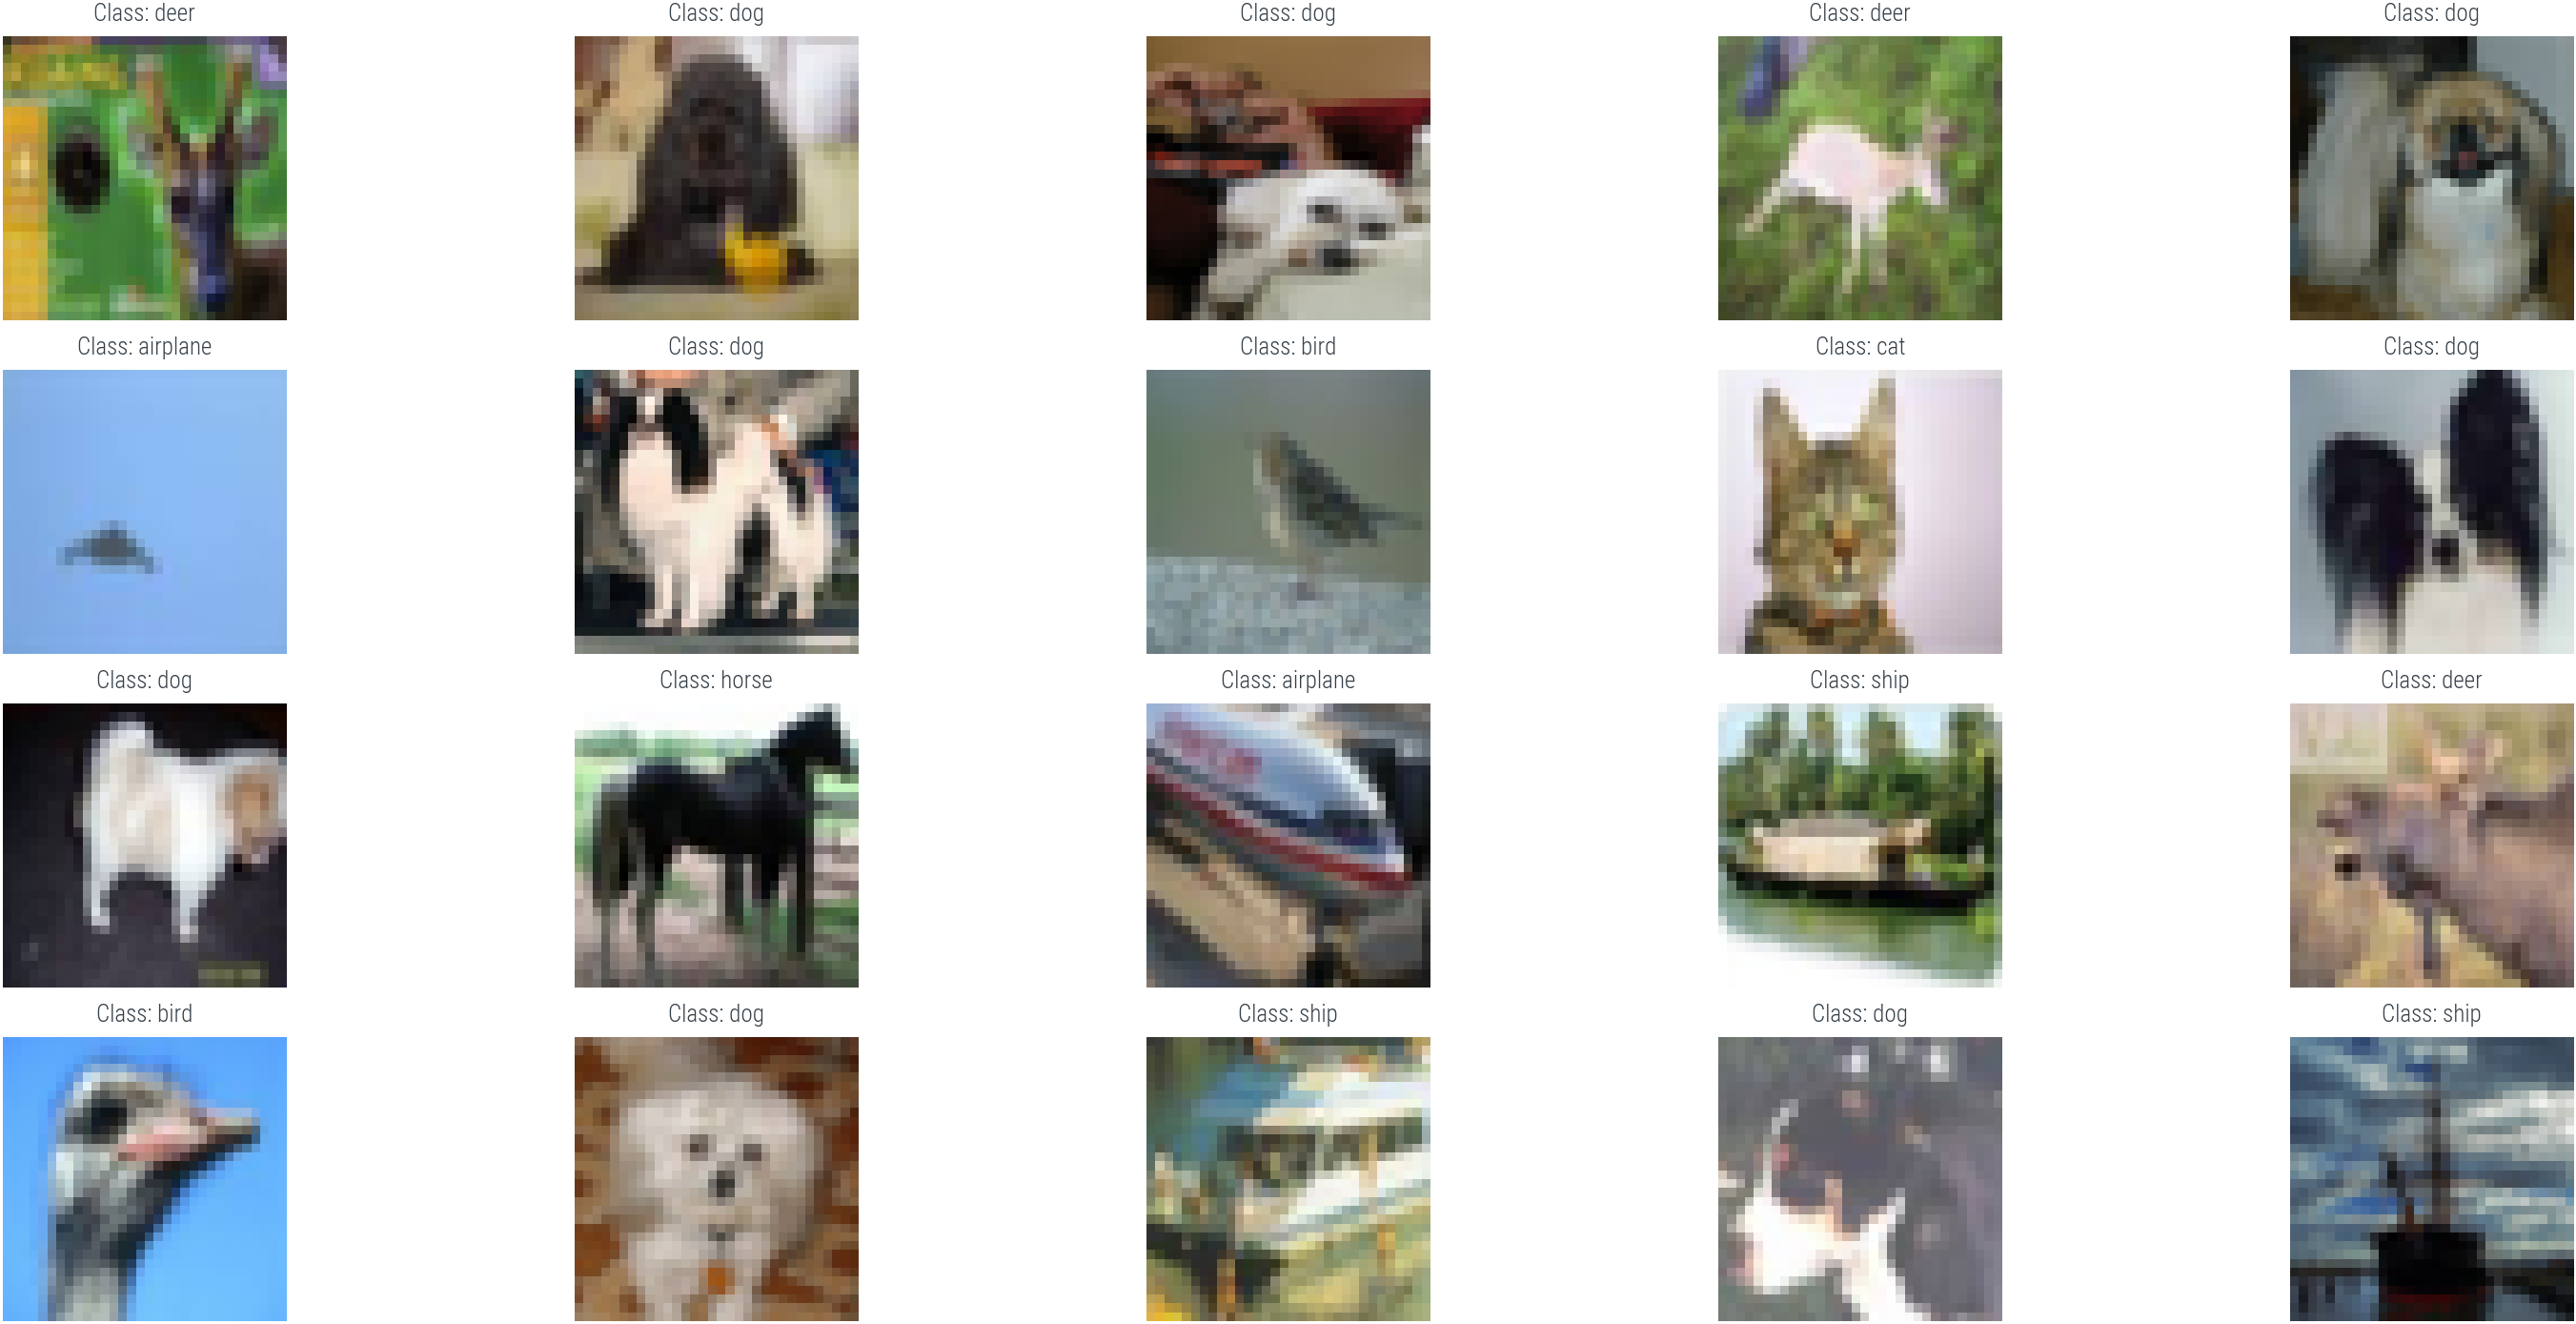

In [174]:
# Define a function to display transformed images from a dataloader with class names
def show_transformed_images_with_class_names(dataloader, classes, num_images=20):
    # Get a batch of data from the dataloader
    dataiter = iter(dataloader)
    images, labels = next(dataiter)

    # Plot the transformed images with class names
    plt.figure(figsize=(15, 7))
    for i in range(num_images):
        plt.subplot(4, 5, i + 1)
        image = images[i]  # No need to convert it to PIL, it's already a tensor
        image = image / 2 + 0.5  # Unnormalize the image
        image = transforms.ToPILImage()(image)  # Convert tensor to PIL image
        plt.imshow(image)
        class_name = classes[labels[i].item()]
        plt.title(f"Class: {class_name}")
        plt.axis('off')

    plt.show()

# Plot 20 transformed images from the train_loader with class names
show_transformed_images_with_class_names(train_loader, classes, num_images=20)

In [175]:
# Simple CNN model 
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

import torch.nn as nn
import torch.nn.functional as F

class Featurizer(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 3 input channels, 6 output channels, 5x5 kernel
        self.pool = nn.MaxPool2d(2, 2) # 2x2 max pooling
        self.conv2 = nn.Conv2d(6, 16, 5) # 6 input channels, 16 output channels, 5x5 kernel

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # conv1 -> relu -> pool
        x = self.pool(F.relu(self.conv2(x))) # conv2 -> relu -> pool
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        return x

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 16 * 5 * 5 input features, 120 output features
        self.fc2 = nn.Linear(120, 84) # 120 input features, 84 output features
        self.fc3 = nn.Linear(84, 10) # 84 input features, 10 output features

    def forward(self, x):
        x = F.gelu(self.fc1(x)) # fc1 -> relu
        x = F.gelu(self.fc2(x)) # fc2 -> relu
        x = self.fc3(x) # fc3
        return x

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.featurizer = Featurizer()
        self.classifier = Classifier()

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x
    

# Train loader to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = Net().to(device)

In [176]:
net

Net(
  (featurizer): Featurizer(
    (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  )
  (classifier): Classifier(
    (fc1): Linear(in_features=400, out_features=120, bias=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [177]:
# Number of parameters in the model
sum(p.numel() for p in net.parameters())

62006

In [178]:
net(torch.randn(1, 3, 32, 32).to(device)).shape

torch.Size([1, 10])

In [179]:
net.featurizer(torch.randn(1, 3, 32, 32).to(device)).shape

torch.Size([1, 400])

In [180]:
# Run the featurizer on a batch of images from the train_loader
net.featurizer(next(iter(train_loader))[0].to(device)).shape

torch.Size([32, 400])

In [181]:
def get_features(net, dataloader):
    # Get features of all train images
    feature_set = []
    labels_set = []
    with torch.no_grad():
        for images, labels in tqdm(train_loader):
            features = net.featurizer(images.to(device)).cpu().numpy()
            feature_set.append(features)
            labels_set.append(labels.cpu().numpy())
        fs = np.concatenate(feature_set)
        ls = np.concatenate(labels_set)
    return fs, ls

In [182]:
fs, ls = get_features(net, train_loader)
pd.DataFrame(fs).describe()

100%|██████████| 16/16 [00:00<00:00, 72.23it/s]


,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.002070,0.002484,0.001423,0.002050,0.001363,0.002782,0.002047,0.002103,0.002585,0.002406,...,0.282767,0.281797,0.281827,0.281136,0.269388,0.278801,0.281705,0.278107,0.268824,0.259713
std,0.012357,0.012672,0.007450,0.011089,0.008920,0.012236,0.010117,0.010382,0.012293,0.012843,...,0.100772,0.099586,0.096688,0.096832,0.106759,0.105216,0.102951,0.098530,0.106234,0.110861
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.037940,0.000000,0.063542,0.043052,0.002858,0.041352,0.024274,0.005828,0.033777,0.004035
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.217203,0.207955,0.214221,0.206354,0.186963,0.202869,0.205474,0.204013,0.189549,0.171866
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.281949,0.273942,0.278046,0.278744,0.266316,0.271570,0.284014,0.280607,0.272538,0.263997
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.347674,0.355528,0.352839,0.350960,0.352536,0.348564,0.348034,0.349340,0.345126,0.338546
max,0.162442,0.116868,0.088642,0.112074,0.126818,0.116622,0.100320,0.083529,0.099598,0.121210,...,0.568702,0.580709,0.573936,0.605211,0.612981,0.648975,0.633854,0.529317,0.584862,0.650028


100%|██████████| 16/16 [00:00<00:00, 72.93it/s]


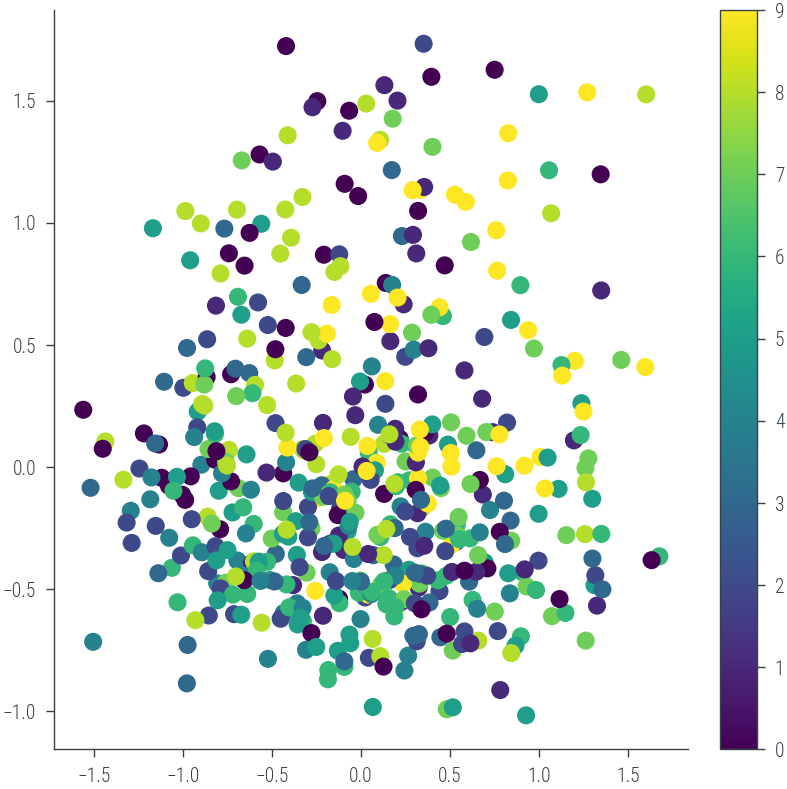

In [183]:
def plot_PCA_embedding(net, dataloader):
    fs, ls = get_features(net, dataloader)
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(fs)

    plt.figure(figsize=(4, 4))
    plt.scatter(features_pca[:, 0], features_pca[:, 1], c=ls)
    plt.colorbar()
    
plot_PCA_embedding(net, train_loader)

In [184]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [185]:
def train(net, data_loader, lr=0.001, epochs=100):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    losses = []
    for epoch in range(epochs):
        # Load a batch of data from the train_loader
        for i, data in enumerate(data_loader):
            # Get the inputs
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Print statistics
        losses.append(loss.item())
        if epoch % 20 == 0:
            print(f'Epoch {epoch + 1}, loss {loss.item():.3f}')
    return losses

losses = train(net, train_loader, lr=0.001, epochs=100)

Epoch 1, loss 2.445
Epoch 21, loss 0.297
Epoch 41, loss 0.015
Epoch 61, loss 0.002
Epoch 81, loss 0.002


Text(0, 0.5, 'Loss')

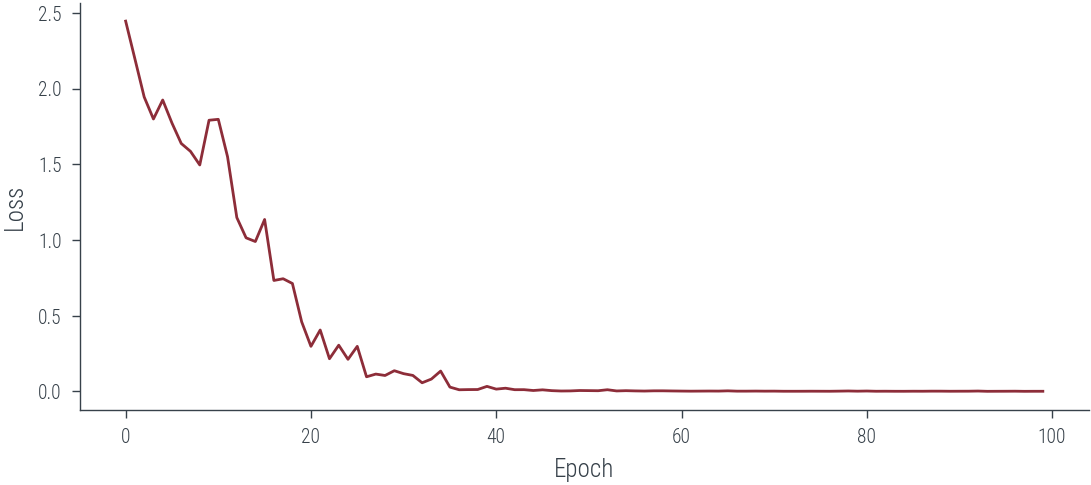

In [186]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

100%|██████████| 16/16 [00:00<00:00, 74.10it/s]


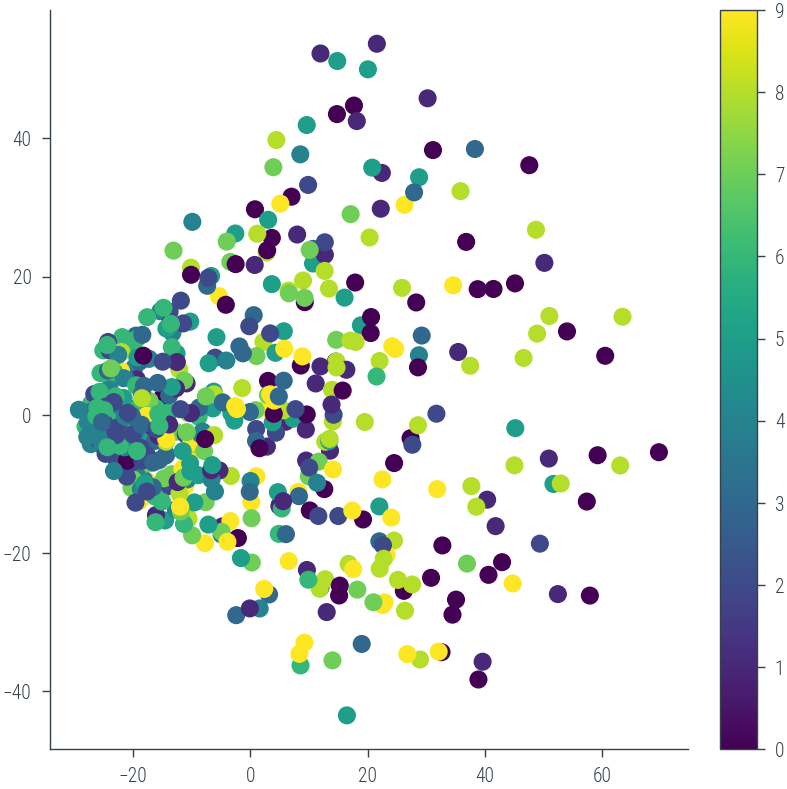

In [187]:
plot_PCA_embedding(net, train_loader)

In [188]:
# Obtain the confusion matrix for the test set
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(net, dataloader):
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    return confusion_matrix(y_true, y_pred)

test_cm = get_confusion_matrix(net, test_loader)

100%|██████████| 32/32 [00:00<00:00, 129.86it/s]


Text(0.5, 1.0, 'Test Confusion Matrix')

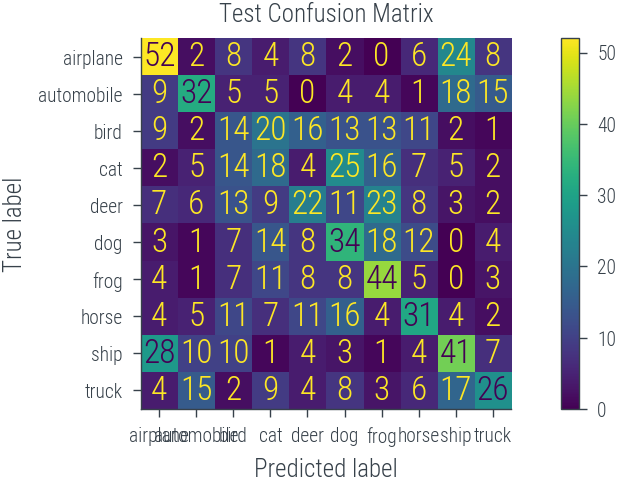

In [189]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay(test_cm, display_labels=classes).plot()
plt.title("Test Confusion Matrix")

100%|██████████| 16/16 [00:00<00:00, 67.65it/s]


Text(0.5, 1.0, 'Train Confusion Matrix')

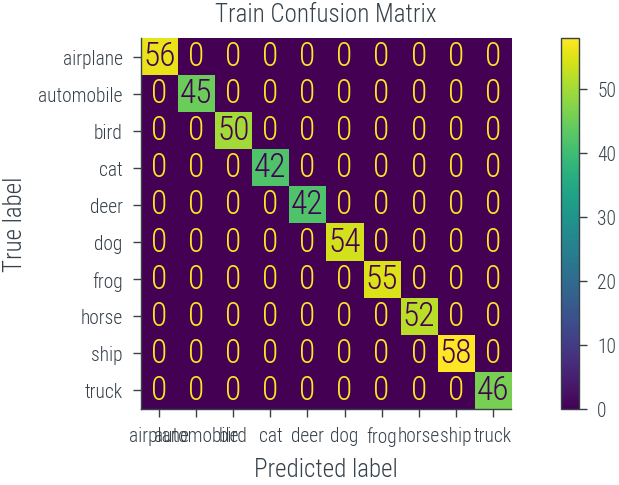

In [190]:
ConfusionMatrixDisplay(get_confusion_matrix(net, train_loader), display_labels=classes).plot()
plt.title("Train Confusion Matrix")

In [191]:
from sklearn.metrics import accuracy_score, f1_score

def get_accuracy_and_f1_scores(net, dataloader):
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

accuracy_score_test, f1_score_test = get_accuracy_and_f1_scores(net, test_loader)
print(f'Test Accuracy: {accuracy_score_test:.3f}')
print(f'Test F1 score: {f1_score_test:.3f}')

accuracy_score_train, f1_score_train = get_accuracy_and_f1_scores(net, train_loader)
print(f'Train Accuracy: {accuracy_score_train:.3f}')
print(f'Train F1 score: {f1_score_train:.3f}')


100%|██████████| 32/32 [00:00<00:00, 128.99it/s]


Test Accuracy: 0.314
Test F1 score: 0.310


100%|██████████| 16/16 [00:00<00:00, 70.79it/s]

Train Accuracy: 1.000
Train F1 score: 1.000


In [225]:
a = torch.tensor([1, 2, 3, 4, 5])
b = torch.tensor([1, 3, 5])

torch_set_diff1d(a, b)

tensor([2, 4])

In [279]:
def al_loop(net, query_strategy, n_steps, pool_indices, train_indices, test_indices, n_samples=10, random_seed=42):
    assert type(pool_indices) == torch.Tensor, "pool_indices should be a PyTorch tensor"
    assert type(train_indices) == torch.Tensor, "train_indices should be a PyTorch tensor"
    assert type(test_indices) == torch.Tensor, "test_indices should be a PyTorch tensor"
    
    
    # Assert for devices (CPU or GPU)
    assert device==pool_indices.device == train_indices.device == test_indices.device, "All tensors should be on the same device"
    # Set random seed for reproducibility
    np.random.seed(random_seed)
    train_losses = []
    test_f1s = []
    test_accs = []
    
    
    for i in tqdm(range(n_steps)):
                
        train_loader = DataLoader(Subset(ds_cifar, train_indices), batch_size=32, shuffle=True, pin_memory=True)
        test_loader = DataLoader(Subset(ds_cifar, test_indices), batch_size=32, shuffle=True)
        
        # Train the net on train_loader
        losses = train(net, train_loader, lr=0.001, epochs=2)
        train_losses.append(losses[-1])
        
        # Get accuracy and f1 scores on test set
        accuracy_score_test, f1_score_test = get_accuracy_and_f1_scores(net, test_loader)
        
        test_accs.append(accuracy_score_test)
        test_f1s.append(f1_score_test)
        
        # Get accuracy and f1 scores on train set
        accuracy_score_train, f1_score_train = get_accuracy_and_f1_scores(net, train_loader)
        
        # Get indices from pool with query strategy
        idx = query_strategy(net, pool_indices, n_samples)
        assert type(idx) == torch.Tensor, "query_strategy should return a PyTorch tensor"
        assert idx.device == pool_indices.device, "query_strategy should return a tensor on the same device as pool_indices"
    
        # Add queried indices to train_indices
        assert type(train_indices) == torch.Tensor, "train_indices should be a PyTorch tensor"
        
        # Assert same device for train_indices and pool_indices[idx]
        assert train_indices.device == pool_indices[idx].device, "train_indices and pool_indices[idx] should be on the same device"
        train_indices = torch.cat([train_indices, pool_indices[idx].to(device)]).to(device)
        
        # Remove queried indices from pool_indices
        pool_indices = torch_set_diff1d(pool_indices, pool_indices[idx]).to(device)
    
    return train_losses, test_accs, test_f1s

In [280]:
train_indices.device, pool_indices.device, test_indices.device

(device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0))

In [281]:
type(train_indices), type(pool_indices), type(test_indices)

(torch.Tensor, torch.Tensor, torch.Tensor)

In [282]:
def random_query(net, pool_indices, n_samples):
    pool_loader = DataLoader(Subset(ds_cifar, pool_indices), batch_size=32, shuffle=True)
    # return a random sample of indices from pool_indices
    random_indices = torch.randperm(len(pool_indices))[:n_samples]
    # Move to same device as pool_indices
    random_indices = random_indices.to(pool_indices.device)
    print(random_indices.device, pool_indices.device)
    # Assert same device as pool_indices
    assert random_indices.device == pool_indices.device, "random_indices should be on the same device as pool_indices"
    return random_indices


In [283]:
train_losses, test_accs, test_f1s = al_loop(net, 
                                            random_query, 
                                            20,
                                            pool_indices,
                                            train_indices,
                                            test_indices, 
                                            n_samples=1, 
                                            random_seed=42)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, loss 0.001


  5%|▌         | 1/20 [00:00<00:17,  1.07it/s]

cuda:0 cuda:0
Epoch 1, loss 0.084


 10%|█         | 2/20 [00:01<00:16,  1.07it/s]

cuda:0 cuda:0
Epoch 1, loss 0.024


 15%|█▌        | 3/20 [00:02<00:16,  1.06it/s]

cuda:0 cuda:0
Epoch 1, loss 0.001


 20%|██        | 4/20 [00:03<00:15,  1.06it/s]

cuda:0 cuda:0
Epoch 1, loss 0.040


 25%|██▌       | 5/20 [00:04<00:13,  1.08it/s]

cuda:0 cuda:0
Epoch 1, loss 0.388


 30%|███       | 6/20 [00:05<00:12,  1.08it/s]

cuda:0 cuda:0
Epoch 1, loss 0.000


 35%|███▌      | 7/20 [00:06<00:12,  1.08it/s]

cuda:0 cuda:0
Epoch 1, loss 0.411


 40%|████      | 8/20 [00:07<00:11,  1.08it/s]

cuda:0 cuda:0
Epoch 1, loss 0.001


 45%|████▌     | 9/20 [00:08<00:10,  1.08it/s]

cuda:0 cuda:0
Epoch 1, loss 0.229


 50%|█████     | 10/20 [00:09<00:09,  1.07it/s]

cuda:0 cuda:0
Epoch 1, loss 0.000


 55%|█████▌    | 11/20 [00:10<00:08,  1.07it/s]

cuda:0 cuda:0
Epoch 1, loss 0.000


 60%|██████    | 12/20 [00:11<00:07,  1.06it/s]

cuda:0 cuda:0
Epoch 1, loss 0.001


 65%|██████▌   | 13/20 [00:12<00:06,  1.07it/s]

cuda:0 cuda:0
Epoch 1, loss 0.000


 70%|███████   | 14/20 [00:13<00:05,  1.08it/s]

cuda:0 cuda:0
Epoch 1, loss 0.000


 75%|███████▌  | 15/20 [00:14<00:04,  1.06it/s]

cuda:0 cuda:0
Epoch 1, loss 0.000


 80%|████████  | 16/20 [00:14<00:03,  1.07it/s]

cuda:0 cuda:0
Epoch 1, loss 0.001


 85%|████████▌ | 17/20 [00:15<00:02,  1.07it/s]

cuda:0 cuda:0
Epoch 1, loss 0.009


 90%|█████████ | 18/20 [00:16<00:01,  1.06it/s]

cuda:0 cuda:0
Epoch 1, loss 0.000


 95%|█████████▌| 19/20 [00:17<00:00,  1.03it/s]

cuda:0 cuda:0
Epoch 1, loss 0.000


100%|██████████| 20/20 [00:18<00:00,  1.06it/s]

cuda:0 cuda:0


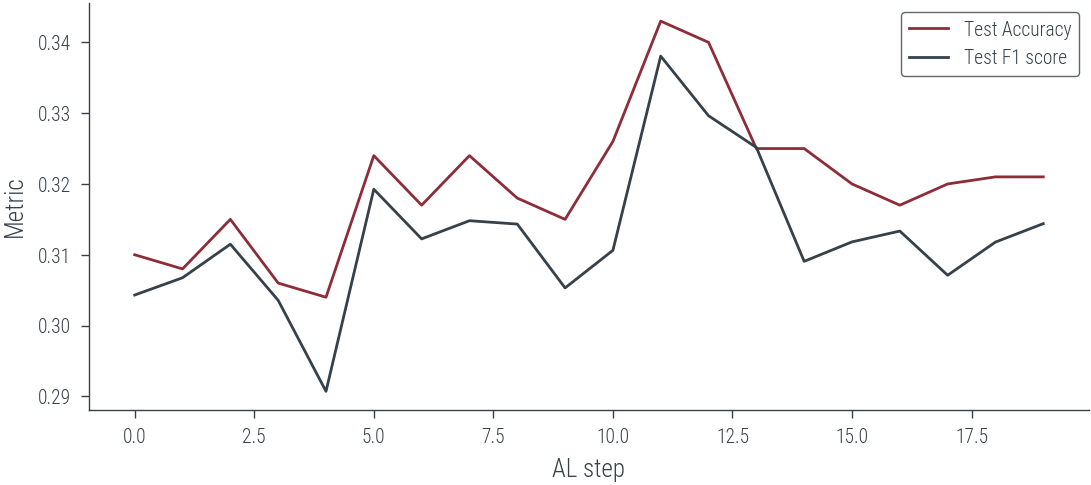

In [284]:
# Plot test accuracy and f1 scores
plt.plot(test_accs, label='Test Accuracy')
plt.plot(test_f1s, label='Test F1 score')
plt.xlabel('AL step')
plt.ylabel('Metric')
plt.legend()

In [72]:
# Random acquisition for AL.
# We will use the pool_loader to randomly select images from the pool
# and add them to the train_loader
# and remove them from the pool_loader

# Define a function to randomly select images from the pool_loader
def random_acquisition(net, pool_loader, num_images=10):
    # Get a batch of data from the pool_loader
    dataiter = iter(pool_loader)
    images, labels = next(dataiter)

    # Randomly select num_images images from the pool_loader
    random_indices = np.random.choice(len(images), num_images, replace=False)
    return random_indices

In [74]:
random_acquisition(net, pool_loader)

array([ 5, 26, 20, 29, 27, 19, 31, 23, 17, 24])

In [75]:
# Copy the train_loader to a new dataloader
from copy import deepcopy
temp_train_loader = deepcopy(train_loader)
temp_train_loader

In [78]:
temp_train_loader.dataset.indices   

tensor([33109, 36480, 21123, 17523,  2530, 27578, 46915,  9801,  9405,  7905,
        21856, 18048, 46364, 40971, 43136, 26402, 18315, 49685, 44712, 43044,
          147, 31520,  7205, 44076, 42501, 27872, 43467, 37172, 38385, 23444,
         6230,  9282, 27373, 45879, 49545, 41389, 27878,  5874, 34223, 37517,
        48650, 42767,  1118, 22753, 20395,  8994, 21374, 47767,  6748, 14165,
        39489, 42724,  5503, 30263, 41252, 14644,  4892,   725, 37213, 20304,
        47522,  8270, 16823, 37286, 25045, 29600, 35539, 35557, 44233, 13538,
        31138, 38242, 29625, 36399, 46088, 21879, 16957,  2741, 24381,  7753,
        18552, 42127, 14170, 12007,  9506, 26396,  6943, 32492, 48386, 42745,
        48216, 43850,  3016,  1640, 37601,  6354, 29644, 24114, 13471, 45577,
        10822,  1414, 12609, 13466, 22062,  9413, 26335, 28102, 15267, 49146,
        45926, 34657,  5987, 27802, 31919,  7134, 29660, 47894, 12851,  5823,
        43281, 26178, 26593,  1122,  3211,  2354, 46956, 39483, 

In [109]:
def entropy_sampling(net, pool_indices, step_size=1):
    pool_loader = DataLoader(Subset(ds_cifar, pool_indices), batch_size=32, shuffle=True)
    # Get a batch of data from the pool_loader
    dictionary = {}
    # Obtain the outputs of the model for all images in the pool_loader
    with torch.no_grad():
        for images, labels in tqdm(pool_loader):
            outputs = net(images.to(device))
            # Calculate the entropy of the outputs
            entropy = - torch.sum(F.softmax(outputs, dim=1) * F.log_softmax(outputs, dim=1), dim=1)
            for i, e in enumerate(entropy):
                dictionary[pool_indices[i]] = e.item()
    # Sort the dictionary by entropy
    sorted_dict = sorted(dictionary.items(), key=lambda x: x[1])
    # Select the top step_size images with highest entropy
    return [x[0] for x in sorted_dict[-step_size:]]
    